# Explore here

In [59]:
# Your code here
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.metrics import *
from prophet import Prophet
from sklearn.multioutput import MultiOutputRegressor, RegressorChain
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

In [60]:
df = pd.read_csv('../data/raw/sales.csv', sep=',')
df.head()

,date,sales
0,2022-09-03 17:10:08.079328,55.292157
1,2022-09-04 17:10:08.079328,53.803211
2,2022-09-05 17:10:08.079328,58.141693
3,2022-09-06 17:10:08.079328,64.530899
4,2022-09-07 17:10:08.079328,66.013633


In [61]:
df

,date,sales
0,2022-09-03 17:10:08.079328,55.292157
1,2022-09-04 17:10:08.079328,53.803211
2,2022-09-05 17:10:08.079328,58.141693
3,2022-09-06 17:10:08.079328,64.530899
4,2022-09-07 17:10:08.079328,66.013633
...,...,...
361,2023-08-30 17:10:08.079328,989.600354
362,2023-08-31 17:10:08.079328,994.987326
363,2023-09-01 17:10:08.079328,995.814415
364,2023-09-02 17:10:08.079328,997.350214


In [62]:
df.shape

(366, 2)

In [63]:
#miramos los tipos de datos y vemos que hay que cambiar a date la fecha porque es un object
df.dtypes

date      object
sales    float64
dtype: object

In [64]:
#vemos si hay valores nulos
df.isna().mean()*100

date     0.0
sales    0.0
dtype: float64

In [65]:
#vemos si hay duplicados
df.duplicated().sum()

np.int64(0)

In [66]:
df.nunique()

date     366
sales    366
dtype: int64

In [67]:
#pasamos a datetime la columna de date
df['date'] = pd.to_datetime(df['date'])
df.dtypes

date     datetime64[ns]
sales           float64
dtype: object

In [68]:
df.head()

,date,sales
0,2022-09-03 17:10:08.079328,55.292157
1,2022-09-04 17:10:08.079328,53.803211
2,2022-09-05 17:10:08.079328,58.141693
3,2022-09-06 17:10:08.079328,64.530899
4,2022-09-07 17:10:08.079328,66.013633


In [69]:
#las horas son las mismas, suponemos que es la hora de cierre asi que solo nos interesa la fecha y no la hora
df['date'] = df['date'].dt.date
df.head()

,date,sales
0,2022-09-03,55.292157
1,2022-09-04,53.803211
2,2022-09-05,58.141693
3,2022-09-06,64.530899
4,2022-09-07,66.013633


In [70]:
df.isnull().sum()

date     0
sales    0
dtype: int64

In [71]:
df['date'].min()

datetime.date(2022, 9, 3)

In [72]:
df['date'].max()

datetime.date(2023, 9, 3)

In [73]:
#miramos los difernetes que dias que hay
(df['date'].max() - df['date'].min()).days

365

El tensor de la serie temporal es de 1 días porque se comprime en un año y salen 365 días

In [74]:
#hacemos una lista para ver donde faltan precios
Counter(df[df['date'].isnull()]['sales'].apply(lambda x: x.year))

Counter()

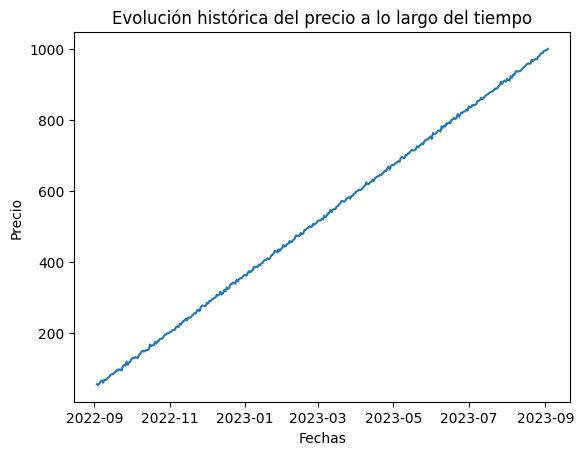

In [75]:
df_aux = df
plt.plot(df_aux['date'], df_aux['sales'])
plt.xlabel('Fechas')
plt.ylabel('Precio')
plt.title('Evolución histórica del precio a lo largo del tiempo')
plt.show()

La tendencia siempre va al alza. Empieza abajo pero va subiendo

In [76]:
desc = df['sales'].describe()
print(desc)

count     366.000000
mean      524.963968
std       275.089698
min        53.803211
25%       290.186822
50%       520.699468
75%       763.289263
max      1000.482785
Name: sales, dtype: float64


La desviación estándar comparada con la media es bastante alta. Por tanto, podemos afirmar que existe variabilidad y ruido.

In [77]:
#Para saber si la serie temporal es estacionaria hacemos el test Dickey-Fuller
#Así sabemos si tiene media, varianza y autocorrelación constante en el tiempo
result = adfuller(df['sales'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Número de lags usados: %d' % result[2])
print('Número de observaciones usadas: %d' % result[3])

ADF Statistic: 0.545414
p-value: 0.986190
Número de lags usados: 13
Número de observaciones usadas: 352


Como el p-value es mayor a 0.05 y el ADF no es negativo, la serie no es estacionaria

In [78]:
#a la columna date la indicamos ocmo indice
df.set_index('date', inplace=True, drop=True)
df.head()

,sales
date,
2022-09-03,55.292157
2022-09-04,53.803211
2022-09-05,58.141693
2022-09-06,64.530899
2022-09-07,66.013633


EL tensor de la serie seria los meses porque este df dolo guardadatosde un año. 

In [120]:
#train todos los datos menos los últimos 30 días y test los úiltimos 30 días
df_train, df_test = df.iloc[:-30], df.iloc[-30:]

tengo un problema de compatibilidad e versiones entre numpy y pmdarima, asi que utilizaré ARIMA de stats models

In [121]:
df_train.tail()

,sales
date,
2023-07-31,907.940014
2023-08-01,916.429348
2023-08-02,913.160687
2023-08-03,911.337552
2023-08-04,923.736767


In [122]:
df_test.head()

,sales
date,
2023-08-05,919.252876
2023-08-06,928.476091
2023-08-07,927.673995
2023-08-08,937.307420
2023-08-09,938.137035


In [110]:
#como tengo que utilizar estatsmodels para ARIMA buscamos cuales son los mejores valores 
param_list = [
    (0,1,0),
    (1,1,0),
    (0,1,1),
    (1,1,1),
    (2,1,1),
    (1,1,2),
    (2,1,2)
]
best_aic = float('inf')
best_order = None
best_model = None
for param in param_list:
    try:
        model = ARIMA(df_train['sales'], order=param)
        model_fit = model.fit()
        aic = model_fit.aic
        print(f"ARIMA{param} - AIC: {aic}")
        if aic < best_aic:
            best_aic = aic
            best_order = param
            best_model = model_fit
    except:
        print(f"ARIMA{param} falló")
print("Mejor modelo encontrado:")
print(f"ARIMA{best_order} con AIC = {best_aic}")

/home/vscode/.local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/vscode/.local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/vscode/.local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/vscode/.local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/vscode/.local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred fre

ARIMA(0, 1, 0) - AIC: 2035.0352595783609
ARIMA(1, 1, 0) - AIC: 2031.2254413789526
ARIMA(0, 1, 1) - AIC: 2033.4417777510164


/home/vscode/.local/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/vscode/.local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/vscode/.local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/vscode/.local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/vscode/.local/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoreg

ARIMA(1, 1, 1) - AIC: 1941.4151715064918


/home/vscode/.local/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/vscode/.local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/vscode/.local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/vscode/.local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(2, 1, 1) - AIC: 1829.336932288887


/home/vscode/.local/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/vscode/.local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/vscode/.local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/vscode/.local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/vscode/.local/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoreg

ARIMA(1, 1, 2) - AIC: 1710.9177386953234
ARIMA(2, 1, 2) - AIC: 1710.2176513273862
Mejor modelo encontrado:
ARIMA(2, 1, 2) con AIC = 1710.2176513273862


/home/vscode/.local/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [111]:
#hacemos el modelo con ARIMA
model = ARIMA(df_train['sales'], order=(2,1,2))
model_fit = model.fit()

/home/vscode/.local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/vscode/.local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/vscode/.local/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/vscode/.local/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/vscode/.local/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-i

In [112]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                  336
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -850.109
Date:                Sun, 22 Jun 2025   AIC                           1710.218
Time:                        17:53:01   BIC                           1729.288
Sample:                    09-03-2022   HQIC                          1717.821
                         - 08-04-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8944      0.015     59.214      0.000       0.865       0.924
ar.L2          0.1056      0.015      6.990      0.000       0.076       0.135
ma.L1         -1.9122      0.025    -75.592      0.0

In [115]:
#hhacemos las predicciones
forecast = model_fit.forecast(steps=30)
forecast.index = df_test.index 

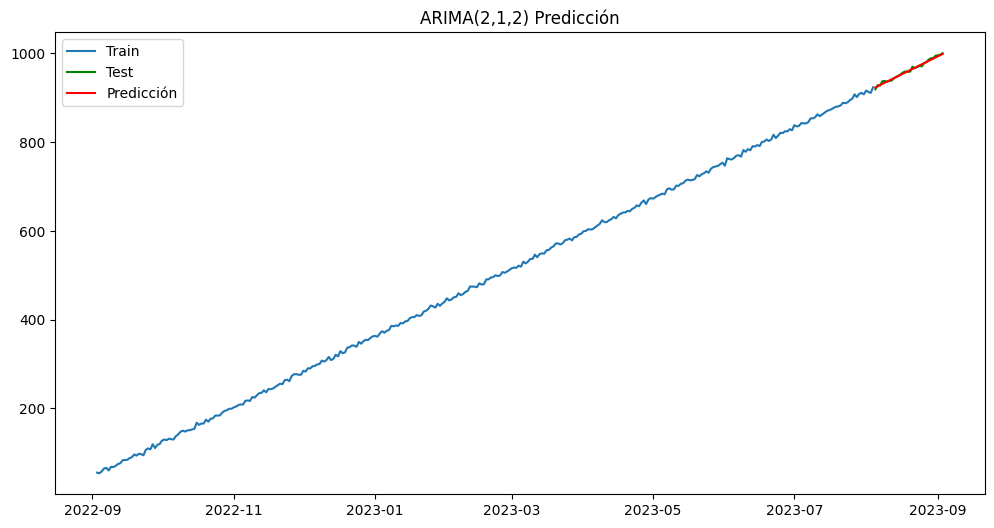

In [117]:
plt.figure(figsize=(12,6))
plt.plot(df_train.index, df_train['sales'], label='Train')
plt.plot(df_test.index, df_test['sales'], label='Test', color='green')
plt.plot(forecast.index, forecast, label='Predicción', color='red')
plt.legend()
plt.title("ARIMA(2,1,2) Predicción")
plt.show()

In [119]:
mae = mean_absolute_error(df_test['sales'], forecast)
mse = mean_squared_error(df_test['sales'], forecast)
rmse = np.sqrt(mse)

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")

MAE: 2.06
MSE: 6.66
RMSE: 2.58


El MAE de 2.06 sobre una media de 525 está muy bien y el RMSE de 2.58 sobre el maximo de 1000 también está muy bien así uqe el modelo se ajusta bien a los datos